In [6]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent  # Assuming notebook is in experiments/notebooks/
sys.path.insert(0, str(project_root))
print(sys.path)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from experiments.analysis_utils.data_processing import read_directory
from experiments.analysis_utils.visualization import plot_reaction_speed_distribution, plot_token_distribution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/home/rotsker/PycharmProjects/dg-research-revision', '/home/rotsker/PycharmProjects/dg-research-revision', '/home/rotsker/miniconda3/envs/radCAD/lib/python312.zip', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/lib-dynload', '', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/site-packages']


In [7]:
# Read the data
# path_to_runs = Path("../../results/simulations/withdrawal_queue_replacement_modified_slow_delay/")
path_to_runs = Path("../../results/simulations/withdrawal_queue_replacement/")
# path_to_runs = Path("../../results/simulations/withdrawal_queue_replacement_different_slow_reaction_limit/")
print(path_to_runs.resolve())
print(path_to_runs.resolve().exists())
proposal_df_full, start_data_df_full, timestep_data_df_full = read_directory(path_to_runs.resolve())
print(len(start_data_df_full))


/home/rotsker/PycharmProjects/dg-research-revision/results/simulations/withdrawal_queue_replacement
True
2000


In [8]:
from experiments.analysis_utils.metrics import analyze_ragequit_timing_by_seals

start_data_df_full['slow_actor_max_delay_days'] = start_data_df_full['slow_actor_max_delay'] / 60 / 60 / 24
ragequit_stats = analyze_ragequit_timing_by_seals(timestep_data_df_full, start_data_df_full, additional_columns=('slow_actor_max_delay_days',))
print("Ragequit statistics by seal parameters:")
display(ragequit_stats)

Ragequit statistics by seal parameters:


ragequit_rate  \
first_seal_rage_quit_support second_seal_rage_quit_support slow_actor_max_delay_days                  
0.01                         0.1                           15.0                          100.000000   
                                                           30.0                          100.000000   
                                                           35.0                          100.000000   
                                                           40.0                           97.000000   
                                                           45.0                           49.500000   
                                                           50.0                           13.666667   
                                                           55.0                            1.333333   
                                                           60.0                            0.000000   

                                                                                      mean_time_to_ragequit  \
first_seal_rage_quit_support second_seal_rage_quit_support slow_actor_max_delay_days                          
0.01                         0.1                           15.0                                  386.045000   
                                                           30.0                                  386.045000   
                                                           35.0                                  386.070000   
                                                           40.0                                  386.030928   
                                                           45.0                                  385.868687   
                                                           50.0                                  385.682927   
                                                           55.0                                  385.500000   
                                                           60.0                                         NaN   

                                                                                      median_time_to_ragequit  \
first_seal_rage_quit_support second_seal_rage_quit_support slow_actor_max_delay_days                            
0.01                         0.1                           15.0                                         386.0   
                                                           30.0                                         386.0   
                                                           35.0                                         386.0   
                                                           40.0                                         386.0   
                                                           45.0                                         386.0   
                                                           50.0                                         386.0   
                                                           55.0                                         385.5   
                                                           60.0                                           NaN   

                                                                                      hours_mean_time_to_ragequit_hours  \
first_seal_rage_quit_support second_seal_rage_quit_support slow_actor_max_delay_days                                      
0.01                         0.1                           15.0                                             1158.135000   
                                                           30.0                                             1158.135000   
                                                           35.0                                             1158.210000   
                                                           40.0                                             1158.092784   
                                                           45.0            

In [9]:
timestep_data_df_full_with_params = timestep_data_df_full.merge(start_data_df_full, on='run_id', how='left')
threshold_times = timestep_data_df_full_with_params.groupby('run_id').apply(lambda x: x[x['actors_total_locked_relative'] >= x['second_seal_rage_quit_support']]['timestep'].min()).reset_index(name='threshold_timestep')
threshold_times['threshold_hours'] = threshold_times['threshold_timestep'] * 3
threshold_times = threshold_times.merge(start_data_df_full, on='run_id', how='left')
threshold_times['slow_actor_max_delay_days'] = threshold_times['slow_actor_max_delay'] / 24 / 60 / 60
threshold_times.groupby(['second_seal_rage_quit_support', 'slow_actor_max_delay_days']).agg({'threshold_hours': ['median', 'mean', 'std', 'min', 'max'], 'run_id': 'count'})


/tmp/ipykernel_4724/3130549630.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  threshold_times = timestep_data_df_full_with_params.groupby('run_id').apply(lambda x: x[x['actors_total_locked_relative'] >= x['second_seal_rage_quit_support']]['timestep'].min()).reset_index(name='threshold_timestep')


threshold_hours  \
                                                                 median   
second_seal_rage_quit_support slow_actor_max_delay_days                   
0.1                           15.0                                219.0   
                              30.0                                366.0   
                              35.0                                414.0   
                              40.0                                462.0   
                              45.0                                507.0   
                              50.0                                555.0   
                              55.0                                600.0   
                              60.0                                657.0   

                                                                     \
                                                               mean   
second_seal_rage_quit_support slow_actor_max_delay_days               
0.1                           15.0                       219.660000   
                              30.0                       364.230000   
                              35.0                       412.300000   
                              40.0                       460.525773   
                              45.0                       507.461538   
                              50.0                       555.437500   
                              55.0                       604.065789   
                              60.0                       655.787234   

                                                                           \
                                                               std    min   
second_seal_rage_quit_support slow_actor_max_delay_days                     
0.1                           15.0                        4.401279  204.0   
                              30.0                        9.463875  330.0   
                              35.0                       11.291368  375.0   
                              40.0                       12.838057  417.0   
                              45.0                       14.282578  459.0   
                              50.0                       15.904195  501.0   
                              55.0                       16.560463  567.0   
                              60.0                       17.035687  618.0   

                                                               run_id  
                                                           max  count  
second_seal_rage_quit_support slow_actor_max_delay_days                
0.1                           15.0                       231.0    200  
                              30.0                       393.0    200  
                              35.0                       447.0    300  
                              40.0                       492.0    300  
                              45.0                       537.0    200  
                              50.0                       585.0    300  
                              55.0                       636.0    300  
                              60.0                       687.0    200

## Below are failed attempts to visualize the relationship between escrow and dynamic timelock

In [53]:
bad_run = timestep_data_df_full_with_params[timestep_data_df_full_with_params['slow_actor_max_delay_days'] == 45].iloc[2].run_id
good_run = timestep_data_df_full_with_params[timestep_data_df_full_with_params['slow_actor_max_delay_days'] == 30].iloc[0].run_id

48.125


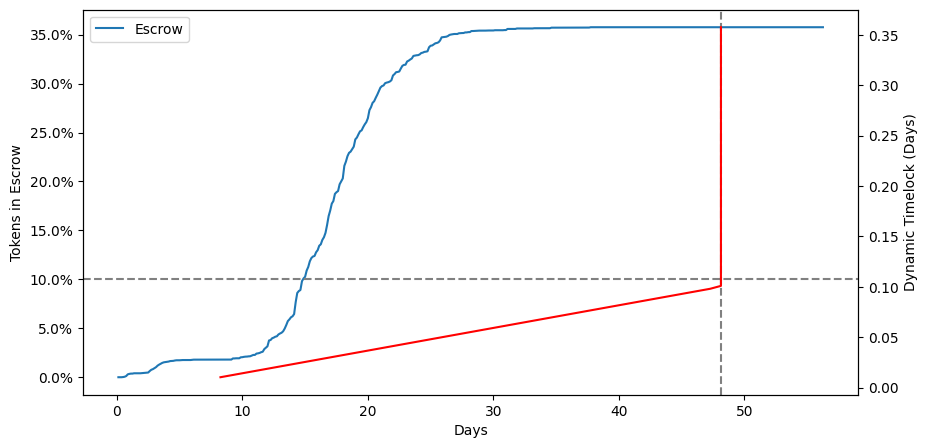

In [139]:
from matplotlib import ticker as mtick

run_id = good_run
timestep_data_df = timestep_data_df_full_with_params[timestep_data_df_full_with_params['run_id'] == run_id]


days = timestep_data_df['timestep'] * 3 / 24
escrow = timestep_data_df['actors_total_locked_relative']
dynamic_timelock_days = timestep_data_df['dg_dynamic_timelock_seconds'] / 3600 / 24

ragequit_day = timestep_data_df[timestep_data_df['dg_state_name'] == 'RageQuit'].timestep.min() * 3 / 24

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(days, escrow, label='Escrow')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_ylabel('Tokens in Escrow')
ax.set_xlabel('Days')

xlim = ax.get_xlim()
ax.plot(xlim, [0.1, 0.1], color='gray', linestyle='--')
ax.set_xlim(xlim)

ylim = ax.get_ylim()
ax.plot([ragequit_day, ragequit_day], ylim, color='gray', linestyle='--')
ax.set_ylim(ylim)

print(ragequit_day)

ax2 = ax.twinx()

mask = (dynamic_timelock_days > 0)
start = timestep_data_df['timestep'][timestep_data_df['dg_dynamic_timelock_seconds'] > 0].min() * 3 / 24
ax2.plot(start + dynamic_timelock_days[mask], escrow[mask], label='Dynamic Timelock', color='red')
ax2.set_ylabel('Dynamic Timelock (Days)')

ax.legend()


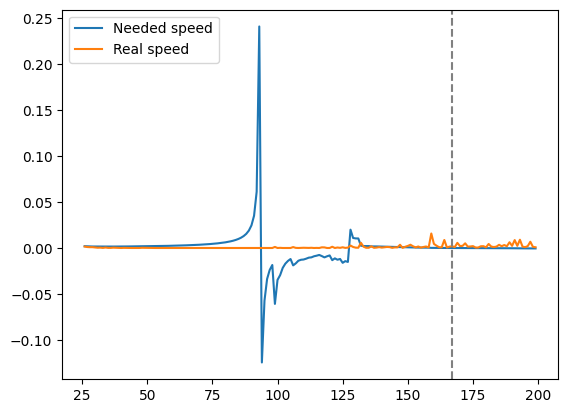

In [108]:
threshold = 0.1
run_id = bad_run
timestep_data_df = timestep_data_df_full_with_params[timestep_data_df_full_with_params['run_id'] == run_id]

escrow = timestep_data_df['actors_total_locked_relative']
hours = timestep_data_df['timestep'] * 3
start_hours = hours[timestep_data_df['dg_state_name'] == 'VetoSignalling'].min()
dynamic_timelock_hours = timestep_data_df['dg_dynamic_timelock_seconds'] / 3600
needed_speed = (threshold - escrow) / (dynamic_timelock_hours - start_hours)
real_speed = escrow.diff() / 3

dynamic_timelock_seconds = timestep_data_df['dg_dynamic_timelock_seconds']

timesteps = timestep_data_df['timestep']
seconds = timesteps * 3 * 60 * 60
start_timestep = timesteps[timestep_data_df['dg_state_name'] == 'VetoSignalling'].min()
start_seconds = start_timestep * 3 * 60 * 60
elapsed_from_start_timesteps = timesteps - start_timestep
elapsed_from_start_seconds = elapsed_from_start_timesteps * 3 * 60 * 60
seconds_left_to_reach_ragequit = dynamic_timelock_seconds - elapsed_from_start_seconds
timesteps_left_to_reach_ragequit = seconds_left_to_reach_ragequit / 3 / 60 / 60
share_left_to_reach_ragequit = threshold - escrow
needed_speed_seconds = share_left_to_reach_ragequit / seconds_left_to_reach_ragequit
needed_speed_timesteps = needed_speed_seconds * 3 * 60 * 60

delta_share = escrow.diff()
delta_timesteps = timesteps.diff()
real_speed_timesteps = delta_share / delta_timesteps


timestep_threshold = timesteps[escrow >= threshold].min()


mask = (timesteps > start_timestep) & (timesteps < 200)
plt.plot(timesteps[mask], needed_speed_timesteps[mask], label='Needed speed')
plt.plot(timesteps[mask], real_speed_timesteps[mask], label='Real speed')

ylim = plt.ylim()
plt.plot([timestep_threshold, timestep_threshold], ylim, color='gray', linestyle='--')
plt.ylim(ylim)
plt.legend()

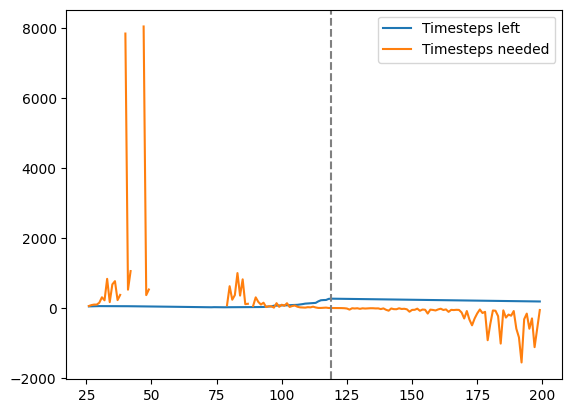

In [132]:
threshold = 0.1
run_id = good_run
timestep_data_df = timestep_data_df_full_with_params[timestep_data_df_full_with_params['run_id'] == run_id]

escrow = timestep_data_df['actors_total_locked_relative']
hours = timestep_data_df['timestep'] * 3
start_hours = hours[timestep_data_df['dg_state_name'] == 'VetoSignalling'].min()
dynamic_timelock_hours = timestep_data_df['dg_dynamic_timelock_seconds'] / 3600
needed_speed = (threshold - escrow) / (dynamic_timelock_hours - start_hours)
real_speed = escrow.diff() / 3

dynamic_timelock_seconds = timestep_data_df['dg_dynamic_timelock_seconds']

timesteps = timestep_data_df['timestep']
seconds = timesteps * 3 * 60 * 60
start_timestep = timesteps[timestep_data_df['dg_state_name'] == 'VetoSignalling'].min()
start_seconds = start_timestep * 3 * 60 * 60
elapsed_from_start_timesteps = timesteps - start_timestep
elapsed_from_start_seconds = elapsed_from_start_timesteps * 3 * 60 * 60
seconds_left_to_reach_ragequit = dynamic_timelock_seconds - elapsed_from_start_seconds
timesteps_left_to_reach_ragequit = seconds_left_to_reach_ragequit / 3 / 60 / 60
share_left_to_reach_ragequit = threshold - escrow
needed_speed_seconds = share_left_to_reach_ragequit / seconds_left_to_reach_ragequit
needed_speed_timesteps = needed_speed_seconds * 3 * 60 * 60

delta_share = escrow.diff()
delta_timesteps = timesteps.diff()
real_speed_timesteps = delta_share / delta_timesteps

timesteps_needed_to_reach_ragequit = (threshold - escrow) / real_speed_timesteps


timestep_threshold = timesteps[escrow >= threshold].min()


mask = (timesteps > start_timestep) & (timesteps < 200)
plt.plot(timesteps[mask], timesteps_left_to_reach_ragequit[mask], label='Timesteps left')
plt.plot(timesteps[mask], timesteps_needed_to_reach_ragequit[mask], label='Timesteps needed')

ylim = plt.ylim()
plt.plot([timestep_threshold, timestep_threshold], ylim, color='gray', linestyle='--')
plt.ylim(ylim)
plt.legend()

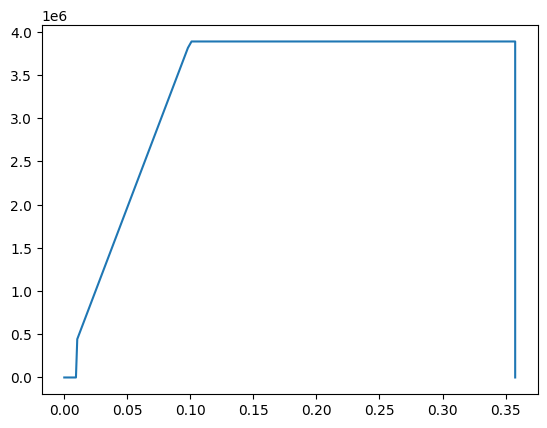

In [133]:
plt.plot(escrow, dynamic_timelock_seconds)

In [134]:
s, e = 50, 100

dynamic_timelock_timesteps = dynamic_timelock_seconds / 3 / 60 / 60

d_s = np.array(dynamic_timelock_timesteps.diff())[e]
d_es = np.array(escrow.diff())[e]
print(d_s, d_es, (d_s / d_es))



3.337685185185194 0.0009387292194230623 3555.5356285133175


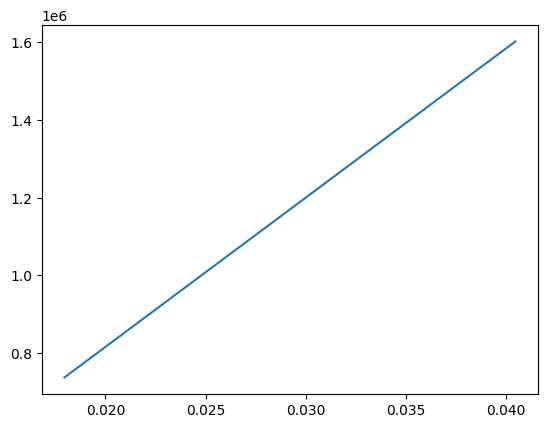

In [147]:
plt.plot(escrow.iloc[50:100], dynamic_timelock_seconds.iloc[50:100])

In [162]:
(dynamic_timelock_timesteps.iloc[100-30] - dynamic_timelock_timesteps.iloc[50]) / (escrow.iloc[100-30] - escrow.iloc[50])








np.float64(3555.398860707864)

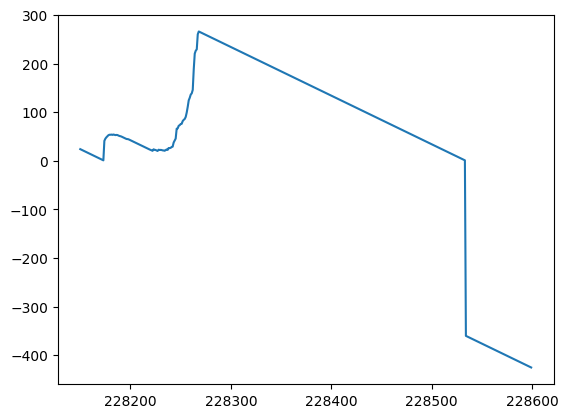

In [164]:
plt.plot(timesteps_left_to_reach_ragequit)